#### 8. Train a ```LinearSVC``` on a linearly separable dataset. The train an SVC and a ```SGDClassifier``` on the same dataset. See if you can get them to produce roughly the same model

In [1]:
import numpy as np
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]
y = iris["target"] 

setosa_or_versicolor = (y == 0) | (y == 1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

In [3]:
C = 5
alpha = 1 / (C * len(X))

lin_clf = LinearSVC(loss="hinge", C=C)
svm_clf = SVC(kernel="linear", C=C)
sgd_clf = SGDClassifier(loss="hinge", learning_rate="constant", eta0=0.001, alpha=alpha,
                        max_iter=1000, tol=1e-3)

In [4]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

lin_clf.fit(X_scaled, y)
svm_clf.fit(X_scaled, y)
sgd_clf.fit(X_scaled, y)

SGDClassifier(alpha=0.002, eta0=0.001, learning_rate='constant')

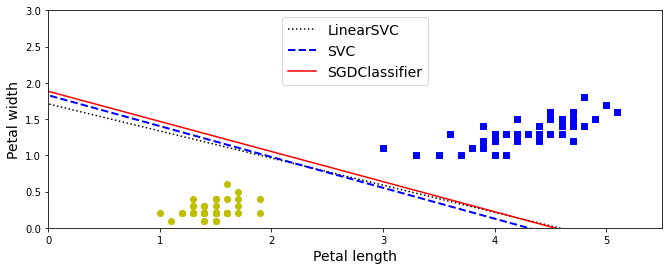

In [5]:
# Compute the slope and bias of each decision boundary
w1 = -lin_clf.coef_[0, 0]/lin_clf.coef_[0, 1]
b1 = -lin_clf.intercept_[0]/lin_clf.coef_[0, 1]
w2 = -svm_clf.coef_[0, 0]/svm_clf.coef_[0, 1]
b2 = -svm_clf.intercept_[0]/svm_clf.coef_[0, 1]
w3 = -sgd_clf.coef_[0, 0]/sgd_clf.coef_[0, 1]
b3 = -sgd_clf.intercept_[0]/sgd_clf.coef_[0, 1]

# Transform the decision boundary lines back to the original scale
line1 = scaler.inverse_transform([[-10, -10 * w1 + b1], [10, 10 * w1 + b1]])
line2 = scaler.inverse_transform([[-10, -10 * w2 + b2], [10, 10 * w2 + b2]])
line3 = scaler.inverse_transform([[-10, -10 * w3 + b3], [10, 10 * w3 + b3]])

# Plot all three decision boundaries
plt.figure(figsize=(11, 4))
plt.plot(line1[:, 0], line1[:, 1], "k:", label="LinearSVC")
plt.plot(line2[:, 0], line2[:, 1], "b--", linewidth=2, label="SVC")
plt.plot(line3[:, 0], line3[:, 1], "r-", label="SGDClassifier")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs") # label="Iris versicolor"
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo") # label="Iris setosa"
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper center", fontsize=14)
plt.axis([0, 5.5, 0, 3])

plt.show()

#### 9. Train an SVM classifier on the MNIST dataset. Since SVM classifiers are binary classifiers, you will need to use one-versus-the-rest the classify all 10 digits. You may want to tune the hyperparameters using small validation sets to speed up the process

In [6]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)

X, y = mnist['data'], mnist['target']

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
lin_clf = LinearSVC()
lin_clf.fit(X_train_scaled, y_train)

C:\Users\Tom\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC()

In [10]:
from sklearn.metrics import accuracy_score

y_pred = lin_clf.predict(X_train_scaled)
accuracy_score(y_train, y_pred)

0.9218833333333334

In [11]:
# new model

svm_clf = SVC()
svm_clf.fit(X_train_scaled, y_train)

SVC()

In [12]:
y_pred = svm_clf.predict(X_train_scaled)
accuracy_score(y_train, y_pred)

0.9866333333333334

In [13]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

param_distributions = {"gamma": reciprocal(0.001, 0.1), "C": uniform(1, 10)}
rnd_search_cv = RandomizedSearchCV(svm_clf, param_distributions, n_iter=10, n_jobs=-1, verbose=2, cv=3)
rnd_search_cv.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000023B81B02FD0>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000023B81B02820>},
                   verbose=2)

In [14]:
rnd_search_cv.best_estimator_.fit(X_train_scaled, y_train)

SVC(C=8.412438523076489, gamma=0.001120536111793748)

In [15]:
y_pred = rnd_search_cv.best_estimator_.predict(X_train_scaled)
accuracy_score(y_train, y_pred)

0.99815

In [16]:
# make preds on test

y_pred = rnd_search_cv.best_estimator_.predict(X_test_scaled)
accuracy_score(y_test, y_pred)

0.9733

#### 10. Train an SVM regressor on the California housing dataset

In [17]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
X = housing["data"]
y = housing["target"]

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [19]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [20]:
from sklearn.svm import SVR

param_distributions = {"gamma": reciprocal(0.001, 0.1), "C": uniform(1, 10)}
rnd_search_cv = RandomizedSearchCV(SVR(), param_distributions, n_iter=10, verbose=2, cv=3)
rnd_search_cv.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END ....C=8.815111680565561, gamma=0.008145425436996387; total time=  10.2s
[CV] END ....C=8.815111680565561, gamma=0.008145425436996387; total time=  10.2s
[CV] END ....C=8.815111680565561, gamma=0.008145425436996387; total time=  10.2s
[CV] END ......C=4.62467356152016, gamma=0.02502478165839214; total time=  10.2s
[CV] END ......C=4.62467356152016, gamma=0.02502478165839214; total time=  10.2s
[CV] END ......C=4.62467356152016, gamma=0.02502478165839214; total time=  10.4s
[CV] END .....C=3.751817325847691, gamma=0.05098439043075555; total time=  10.2s
[CV] END .....C=3.751817325847691, gamma=0.05098439043075555; total time=  10.3s
[CV] END .....C=3.751817325847691, gamma=0.05098439043075555; total time=  10.2s
[CV] END ...C=2.977246788637401, gamma=0.0068798259974002475; total time=  10.1s
[CV] END ...C=2.977246788637401, gamma=0.0068798259974002475; total time=  10.1s
[CV] END ...C=2.977246788637401, gamma=0.0068798

RandomizedSearchCV(cv=3, estimator=SVR(),
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000023BB63A3BB0>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000023BB63A3910>},
                   verbose=2)

In [22]:
# RMSE on train set

from sklearn.metrics import mean_squared_error

y_pred = rnd_search_cv.best_estimator_.predict(X_train_scaled)
mse = mean_squared_error(y_train, y_pred)
np.sqrt(mse)

0.5624670081857285

In [26]:
# RMSE on test set

y_pred = rnd_search_cv.best_estimator_.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
np.sqrt(mse)

0.5790145693469517